<a href="https://colab.research.google.com/github/balilarder/master-ncku/blob/master/wavelet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. input a time series, interpolate, wavelet coefficient...
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from datetime import datetime

# read air pollution csv file

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/My Drive/master_research/dataset/beijing_17_18_aq.csv")    

stations_data = df.groupby('stationId')
# stations 為所有北京不同的station
stations = list(stations_data.groups.keys())
# for each station, generate its time series


date_rng = pd.date_range(start='1/1/2017 14:00', end='1/31/2018 15:00', freq='H')
def time_series(id, type):
    # id is a sensor, ex: aotizhongxin_aq
    # type is ex: pm25
    timestamp = list(date_rng)
    value = [np.nan]*len(timestamp)
    
    select = stations_data.get_group(id)
    select = select[['utc_time', type]]

    # fill the data:

    cur = 0
    for i in range(len(select.index)):
        
        for j in range(cur, len(timestamp)):
            
            if str(timestamp[j]) == select.iloc[i]['utc_time']:
                value[j] = select.iloc[i][type]
                cur = j

                break
            
    return value


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# 1d interpolate for np.nan
import math
y = np.array([1, 1, 1, np.nan, np.nan, 2, 2, np.nan, 0])

def interpolate_linear1d(i):
    x = []
    xp = []
    fp = []
#     xp = list(range(len(i)))
    for a in range(len(i)):
        if math.isnan(i[a]):
            x.append(a)
        else:
            xp.append(a)
            fp.append(i[a])

#     print(x)
#     print(xp)
#     print(fp)
    inter = np.interp(x, xp, fp)
    
    for a, b in zip(x, inter):
        i[a] = b
        
    return i

# 使用interpolate
a = interpolate_linear1d(y)
print(a)
print(len(a))

[1.         1.         1.         1.33333333 1.66666667 2.
 2.         1.         0.        ]
9


[453.0, 417.0, 395.0, 420.0, 453.0, 429.0, 211.0, 116.0, 51.0, 38.0, 21.0, 16.0, 23.0, 18.0, 58.0, 176.0, 109.0, 267.0, 260.0, 212.0, 183.0, 136.0, 137.0, 125.0, 153.0, 165.0, 225.0, 275.0, 293.0, 293.0, 287.0, 305.0, 304.0, 266.0, 240.0, 237.0, 232.0, 155.0, 167.0, 170.0, 179.0, 244.0, 296.0, 295.0, 328.0, 397.0, 437.0, 464.0, 483.0, 447.0, 440.0, 463.0, nan, 463.0, 473.0, 488.0, 500.0, 392.0, 338.0, 338.0, 441.0, 333.0, 167.0, 216.0, 291.0, 325.0, 367.0, 322.0, 298.0, 304.0, 346.0, 356.0, 380.0, 328.0, 203.0, 168.0, 159.0, 168.0, 175.0, 256.0, 336.0, 284.0, 275.0, 271.0, 276.0, 267.0, 249.0, 239.0, 223.0, 206.0, 162.0, 184.0, 183.0, 191.0, 219.0, 199.0, 180.0, 184.0, 184.0, 184.0, 176.0, 159.0, 158.0, 171.0, 169.0, 177.0, 170.0, 175.0, 211.0, 216.0, 193.0, 188.0, 200.0, 214.0, 215.0, 221.0, 211.0, 217.0, 220.0, 235.0, 239.0, 235.0, 241.0, 239.0, 224.0, 208.0, 206.0, 200.0, 181.0, 173.0, 166.0, 154.0, 142.0, 167.0, 196.0, 184.0, 156.0, 115.0, 99.0, 95.0, 102.0, 96.0, 100.0, 111.0, 93.

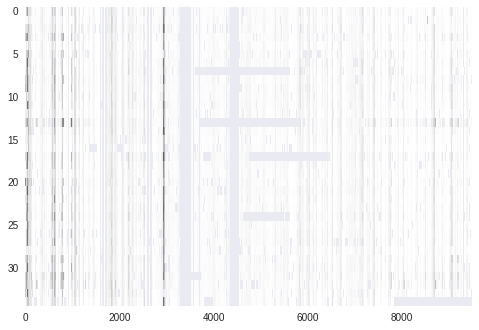

In [0]:
# 以表格方式呈現所有地方time series
d = []

for s in stations:
    v = time_series(s, 'PM2.5')
    dup = list(v)
    dup = dup         # 修正要取的data片段
    print(dup)
#     for n, i in enumerate(dup):
#         if np.isnan(i):
#             dup[n] = 1
            
#         else:
#             dup[n] = 0
    
    d.append(dup)

# # time and missing data之間顏色圖
plt.imshow(d, aspect='auto')
## imshow 裡面有interpolate方式，請注意


plt.grid(b=None)
plt.show()


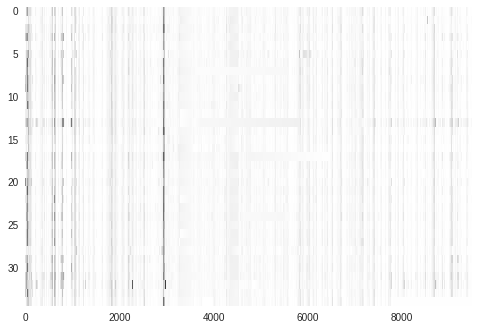

In [0]:
# linear interpolate show

d = []

for s in stations:
    v = time_series(s, 'PM2.5')
    dup = list(v)
    dup = interpolate_linear1d(dup)        

    
    d.append(dup)
plt.imshow(d, aspect='auto')
plt.grid(b=None)
plt.show()

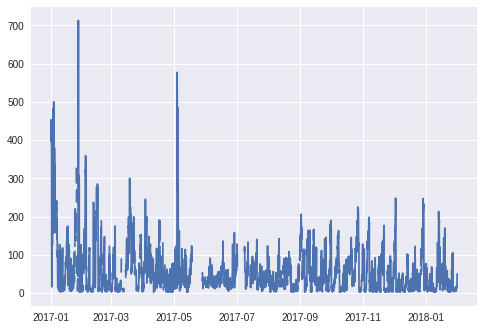

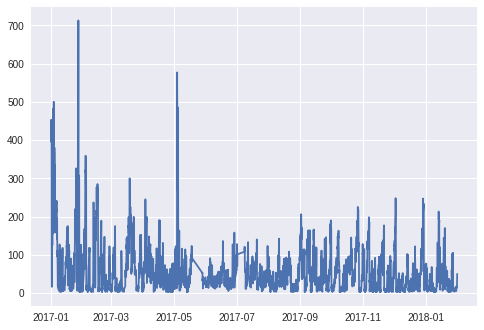

In [0]:
# 可以show出timeseries
v = time_series("aotizhongxin_aq", 'PM2.5')
plt.plot(date_rng, v)
plt.show()

v = interpolate_linear1d(v)
plt.plot(date_rng, v)
plt.show()

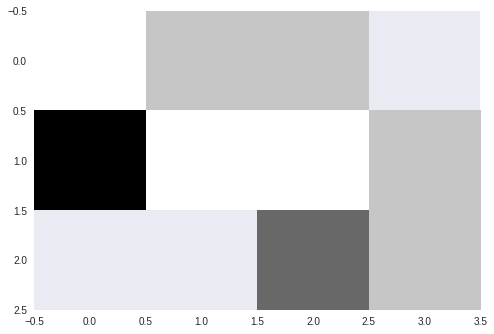

In [0]:
# 有缺值的顯示

d = [[0, 1, 1, np.nan],
     [3, 0, 0, 1],
     [np.nan, np.nan, 2, 1]
    
]
# # time and missing data之間顏色圖
plt.imshow(d, aspect='auto')
## imshow 裡面有interpolate方式，請注意
plt.grid(b=None)
plt.show()

In [3]:
# Wavelet table
# i = [1, 1, 6, 8, 9, 11, 15]
i = time_series("dingling_aq", 'PM2.5')
def wavelet_coefficient_table(i):
    table = [['level', 'average', 'difference']]
    level = 1
    length = len(i)
    
    while(length > 1):
        if length % 2 == 0:
            length_next = int(length / 2)
        else:
            length_next = int((length+1) / 2)

        
#         print(length, length_next, level)
        
        average = ['x']*length_next
        difference = ['x']*length_next
        
        # 偶數
        if length % 2 == 0:
            for x in range(length_next):
                v1 = i[x*2]
                v2 = i[x*2 + 1]
                
#                 print('  ', v1, v2)
                average[x] = float((v1+v2) / 2)
                difference[x] = float((v1-v2) / 2)
        # 奇數
        else:
            # seperate series into 3 pieces
            m = int((length-1)/2)
            middle = i[m]
            before = i[:m]
            after = i[m + 1:]
            
            if len(before) % 2 == 0: # 前半後半可以各自形成
                for x in range(len(before) // 2):
                    v1 = before[x*2]
                    v2 = before[x*2 + 1]
                    average[x] = float((v1+v2) / 2)
                    difference[x] = float((v1-v2) / 2)
                for x, y in zip(range(int(m/2) + 1, length_next), range(len(after) // 2)):
                    v1 = after[y*2]
                    v2 = after[y*2 + 1]
                    average[x] = float((v1+v2) / 2)
                    difference[x] = float((v1-v2) / 2)
                # 中間那格必須和左右一起計算(共填一格)
                average[int((length_next-1)/2)] = (((before[-1]+middle)/2)+
                                                   ((middle+after[0])/2)) / 2
                difference[int((length_next-1)/2)] = (((before[-1]-middle)/2)+
                                                   ((middle-after[0])/2)) / 2
            
            else:
                del before[-1]
                del after[0]
                
                if before != []:
                    for x in range(int(length_next/2) - 1):
                        v1 = before[x*2]
                        v2 = before[x*2 + 1]
                        average[x] = float((v1+v2) / 2)
                        difference[x] = float((v1-v2) / 2)
                    for x, y in zip(range(int(length_next/2) + 1, length_next), range(len(after) // 2)):
                        v1 = after[y*2]
                        v2 = after[y*2 + 1]
                        average[x] = float((v1+v2) / 2)
                        difference[x] = float((v1-v2) / 2)
                # 填2個格子歐
                position1 = int(length_next/2) - 1
                position2 = position1 + 1
                average[position1] = (i[m-1] + middle) / 2
                average[position2] = (middle + i[m+1]) / 2
                difference[position1] = (i[m-1] - middle) / 2
                difference[position2] = (middle - i[m+1]) / 2
                
#         print(' ', average, difference)
        
        length = length_next
        i = average
        
        table.append([level, average, difference])
        level += 1
        
    return table

# for x in table:
#     print(table)

t = wavelet_coefficient_table(i)
print(t)

[['level', 'average', 'difference'], [1, [341.0, 283.5, 39.5, 17.5, 10.5, 9.0, 12.5, 14.5, 31.0, 171.0, 213.0, 198.5, 175.5, 186.0, 188.0, 150.0, 142.0, 146.5, 155.5, 256.0, 212.5, 194.0, 206.5, 184.5, 141.5, 114.5, 74.0, 59.5, 56.5, 47.5, 67.0, 114.5, 131.5, 208.0, 260.0, 248.5, 253.5, 317.0, 411.0, 389.0, 315.5, 221.5, 234.5, 295.5, 184.5, nan, nan, nan, 162.5, 131.5, 137.5, 129.5, 129.0, 153.0, 209.0, 185.5, 171.0, 195.0, 197.0, 209.0, 209.0, 188.0, 195.0, 177.0, 172.5, 211.5, 257.0, 174.0, 33.5, 37.0, 39.0, 39.0, 31.5, 29.5, 26.5, 23.5, 22.0, 21.0, 22.5, 20.0, 21.5, 19.0, 12.5, 5.0, 11.0, 5.0, 12.5, 12.0, 14.5, 12.5, 12.5, 11.5, 9.0, 18.5, 57.0, 59.5, 65.5, 10.5, 6.0, 7.5, 9.5, 37.0, 23.0, 8.5, 5.5, 8.5, 5.5, 10.5, 10.5, 15.5, 14.0, 14.0, 12.5, 22.5, 60.0, 40.5, 27.0, 19.0, 17.5, 19.5, 14.0, 27.5, 15.5, 12.0, 22.5, 38.0, 30.5, 24.0, 21.5, 24.0, 20.0, 15.0, 18.0, 12.0, 9.0, 3.5, 10.0, 14.0, 16.0, 6.5, 14.5, 11.0, 5.5, 12.0, 16.5, 17.0, 11.5, 12.0, 18.5, 18.5, 18.0, 21.0, 39.5, 18.0,

aotizhongxin_aq
9482
1 [435.0, 407.5, 441.0, 163.5, 44.5, 18.5, 20.5, 117.0, 188.0, 236.0, 159.5, 131.0, 159.0, 250.0, 293.0, 296.0, 285.0, 238.5, 193.5, 168.5, 211.5, 295.5, 362.5, 450.5, 465.0, 451.5, 463.0, 480.5, 446.0, 338.0, 387.0, 191.5, 308.0, 344.5, 301.0, 351.0, 354.0, 185.5, 163.5, 215.5, 310.0, 273.0, 271.5, 244.0, 214.5, 173.0, 187.0, 209.0, 182.0, 184.0, 167.5, 164.5, 173.0, 172.5, 213.5, 190.5, 207.0, 218.0, 214.0, 227.5, 237.0, 240.0, 216.0, 203.0, 177.0, 160.0, 154.5, 190.0, 135.5, 97.0, 99.0, 105.5, 85.5, 66.0, 22.5, 21.5, 15.5, 19.0, 18.5, 23.0, 19.5, 13.5, 14.5, 18.0, 11.5, 9.0, 10.0, 6.0, 10.5, 12.5, 12.5, 8.25, 16.0, 35.5, 56.0, 100.5, 123.5, 60.5, 13.0, 7.5, 10.5, 5.5, 4.5, 3.0, 3.0, 6.0, 10.5, 86.0, 85.5, 92.5, 104.5, 83.0, 46.5, 24.0, 17.5, 23.5, 41.5, 65.0, 55.0, 28.0, 28.5, 33.0, 22.0, 31.5, 18.0, 15.5, 20.5, 36.5, 80.5, 86.0, 107.0, 67.5, 15.5, 12.5, 7.5, 7.5, 11.0, 15.0, 16.5, 11.5, 12.0, 6.5, 12.5, 21.0, 13.0, 15.0, 12.5, 19.5, 10.0, 20.0, 30.0, 19.5, 14.5

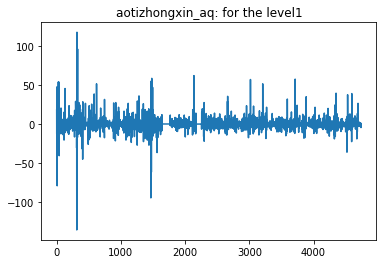

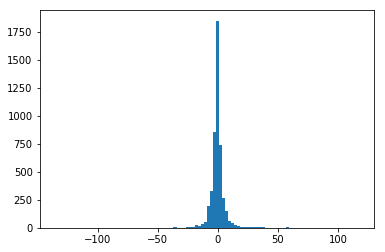

2 [421.25, 302.25, 31.5, 68.75, 212.0, 145.25, 204.5, 294.5, 261.75, 181.0, 253.5, 406.5, 458.25, 471.75, 392.0, 289.25, 326.25, 326.0, 269.75, 189.5, 291.5, 257.75, 193.75, 198.0, 183.0, 166.0, 172.75, 202.0, 212.5, 220.75, 238.5, 209.5, 168.5, 172.25, 116.25, 102.25, 75.75, 22.0, 17.25, 20.75, 16.5, 16.25, 10.25, 8.0, 11.5, 10.375, 25.75, 78.25, 92.0, 10.25, 8.0, 3.75, 4.5, 48.25, 89.0, 93.75, 35.25, 20.5, 53.25, 41.5, 30.75, 26.75, 16.75, 28.5, 83.25, 87.25, 14.0, 7.5, 13.0, 14.0, 9.25, 16.75, 14.0, 16.0, 15.0, 24.75, 15.0, 35.75, 32.75, 39.25, 24.75, 38.25, 65.25, 78.0, 78.5, 87.5, 86.0, 68.0, 101.5, 123.5, 132.5, 135.75, 138.75, 162.5, 141.5, 166.25, 108.25, 50.25, 22.75, 23.0, 40.25, 47.25, 62.25, 105.25, 106.75, 17.5, 9.25, 11.25, 10.0, 7.0, 10.25, 18.0, 21.5, 38.5, 63.75, 82.5, 13.5, 7.75, 6.75, 12.75, 10.75, 13.75, 12.0, 17.5, 28.75, 53.25, 25.75, 16.0, 12.0, 17.5, 30.25, 58.5, 91.125, 96.75, 47.625, 49.25, 95.375, 128.6, 137.9, 199.75, 167.25, 148.25, 164.75, 206.1875, 259.62

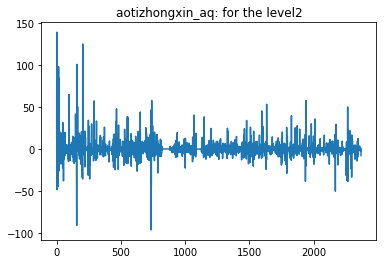

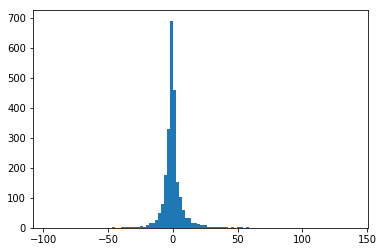

3 [361.75, 50.125, 178.625, 249.5, 221.375, 330.0, 465.0, 340.625, 326.125, 229.625, 274.625, 195.875, 174.5, 187.375, 216.625, 224.0, 170.375, 109.25, 48.875, 19.0, 16.375, 9.125, 10.9375, 52.0, 51.125, 5.875, 26.375, 91.375, 27.875, 47.375, 28.75, 22.625, 85.25, 10.75, 13.5, 13.0, 15.0, 19.875, 25.375, 36.0, 31.5, 71.625, 83.0, 77.0, 112.5, 134.125, 150.625, 153.875, 79.25, 22.875, 43.75, 83.75, 62.125, 10.25, 8.5, 14.125, 30.0, 73.125, 10.625, 9.75, 12.25, 14.75, 41.0, 20.875, 14.75, 44.375, 93.9375, 48.4375, 111.9875, 168.825, 157.75, 185.46875, 286.28125, 241.875, 47.53846153846153, 15.46153846153846, 22.041666666666668, 80.20833333333333, 510.75, 373.625, 244.875, 174.375, 10.5, 9.75, 7.875, 6.625, 47.375, 82.5, 85.75, 64.625, 6.5, 8.375, 19.02777777777778, 34.63888888888889, 49.89583333333333, 95.125, 148.125, 89.125, 205.625, 327.875, 307.125, 222.875, 13.875, 10.625, 10.875, 7.625, 5.25, 13.75, 58.25, 67.25, 92.125, 112.9375, 16.0625, 9.5625, 8.363636363636363, 7.3863636363636

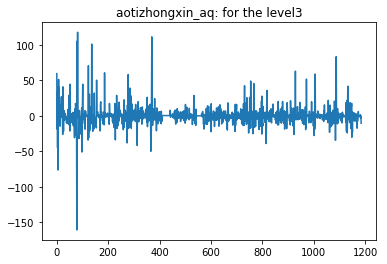

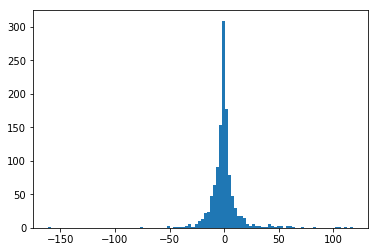

4 [205.9375, 214.0625, 275.6875, 402.8125, 277.875, 235.25, 180.9375, 220.3125, 139.8125, 33.9375, 12.75, 31.46875, 28.5, 58.875, 37.625, 25.6875, 48.0, 13.25, 17.4375, 30.6875, 51.5625, 80.0, 123.3125, 152.25, 51.0625, 63.75, 36.1875, 11.3125, 51.5625, 10.1875, 13.5, 30.9375, 29.5625, 71.1875, 140.40625, 171.609375, 264.078125, 31.499999999999996, 51.125, 442.1875, 209.625, 10.125, 7.25, 64.9375, 75.1875, 7.4375, 26.833333333333336, 72.51041666666666, 118.625, 266.75, 265.0, 12.25, 9.25, 9.5, 62.75, 102.53125, 12.8125, 7.875, 6.625, 7.125, 13.875, 96.3125, 94.875, 116.4375, 94.75, 187.25, 244.6875, 265.890625, 74.359375, 7.6875, 50.5625, 82.125, 156.4375, 22.25, 9.78125, 64.875, 55.8125, 88.4375, 12.875, 27.625, 16.5, 10.625, 16.3125, 28.25, 77.75, 48.3125, 10.25, 10.3125, 10.75, 40.6875, 84.75, 70.75, 94.3125, 41.3125, 10.25, 17.375, 6.34375, 6.5, 10.75, 10.09375, 15.0, 30.875, 77.8125, 13.015625, 7.609375, 6.65625, 10.555147058823529, 16.60110294117647, 50.875, 92.15, 111.8187500000

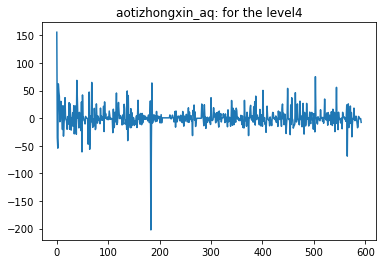

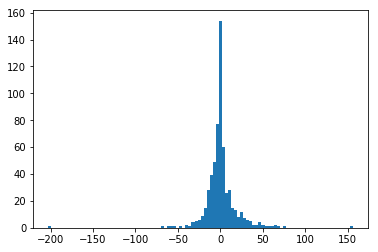

5 [210.0, 339.25, 256.5625, 200.625, 86.875, 22.109375, 43.6875, 31.65625, 30.625, 24.0625, 65.78125, 137.78125, 57.40625, 23.75, 30.875, 22.21875, 50.375, 156.0078125, 147.7890625, 246.65625, 109.875, 36.09375, 41.3125, 49.671875, 192.6875, 138.625, 9.375, 82.640625, 10.34375, 6.875, 55.09375, 105.65625, 141.0, 255.2890625, 41.0234375, 66.34375, 89.34375, 37.328125, 72.125, 20.25, 13.5625, 22.28125, 63.03125, 10.28125, 25.71875, 77.75, 67.8125, 13.8125, 6.421875, 10.421875, 22.9375, 45.4140625, 7.1328125, 13.578125, 71.5125, 103.12812500000001, 150.15625, 214.34375, 102.96875, 129.015625, 116.53125, 53.84375, 12.28125, 20.125, 86.609375, 98.0, 24.875, 45.46875, 114.8125, 107.1875, 72.5, 84.15625, 84.53125, 63.5625, 36.84375, 28.0625, 65.09375, 36.46875, 101.53125, 77.421875, 45.21875, 46.446875, 36.4203125, 28.035773026315788, 30.37828947368421, 12.859375, 17.578125, 27.65625, 44.90625, 39.0625, 61.40625, 170.90625, 246.09375, 51.171875, 37.171875, 53.65625, 41.5, 43.15625, 35.953125,

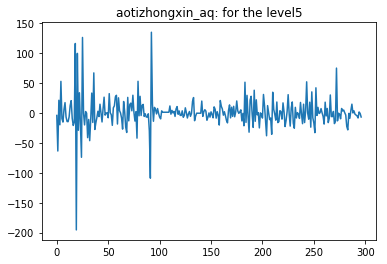

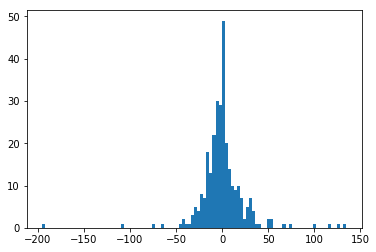

6 [274.625, 228.59375, 54.4921875, 37.671875, 27.34375, 101.78125, 40.578125, 26.546875, 103.19140625, 197.22265625, 72.984375, 45.4921875, 165.65625, 46.0078125, 8.609375, 80.375, 198.14453125, 53.68359375, 63.3359375, 46.1875, 17.921875, 36.65625, 51.734375, 40.8125, 8.421875, 34.17578125, 10.35546875, 87.3203125, 182.25, 115.9921875, 85.1875, 16.203125, 92.3046875, 35.171875, 111.0, 78.328125, 74.046875, 32.453125, 50.78125, 89.4765625, 45.8328125, 32.228042763157895, 21.618832236842103, 22.6171875, 41.984375, 116.15625, 148.6328125, 45.4140625, 42.328125, 25.625, 47.6875, 90.78732287449392, 79.4493927125506, 69.08502024291498, 58.72064777327935, 32.9768471659919, 25.32451923076923, 40.03125, 40.796875, 21.84375, 31.234375, 36.1875, 66.234375, 32.9375, 27.2109375, 22.546875, 71.3828125, 72.48234097633136, 102.59467455621301, 105.2455621301775, 84.7555473372781, 50.30798611111111, 32.223263888888894, 54.671875, 56.421875, 68.890625, 25.9609375, 31.625, 31.0234375, 53.203125, 39.84375

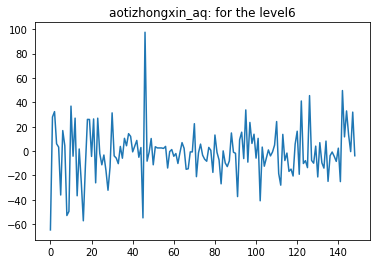

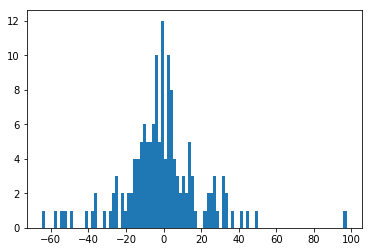

7 [251.609375, 46.08203125, 64.5625, 33.5625, 150.20703125, 59.23828125, 105.83203125, 44.4921875, 125.9140625, 54.76171875, 27.2890625, 46.2734375, 21.298828125, 48.837890625, 149.12109375, 50.6953125, 63.73828125, 94.6640625, 53.25, 70.12890625, 39.030427631578945, 22.11800986842105, 79.0703125, 97.0234375, 33.9765625, 69.23741143724696, 74.2672064777328, 45.848747469635626, 32.67788461538461, 31.3203125, 33.7109375, 49.5859375, 24.87890625, 71.93257673816568, 103.92011834319526, 67.53176672419461, 43.44756944444445, 59.1015625, 47.42578125, 31.32421875, 46.5234375, 20.84375, 47.203125, 44.6328125, 48.83203125, 17.56640625, 92.35546875, 66.3203125, 59.80859375, 36.33203125, 56.328125, 56.56640625, 33.5234375, 57.5859375, 38.3203125, 74.484375, 106.859375, 41.0234375, 77.8984375, 28.8984375, 26.5546875, 64.0, 35.06640625, 60.84375, 17.04296875, 27.64453125, 22.59375, 28.546875, 97.5859375, 23.6640625, 17.0625, 61.2109375, 50.8203125, 16.390625, 26.78125] [23.015625, 8.41015625, -37.21

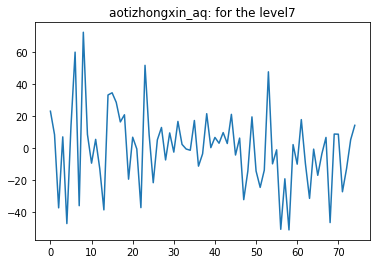

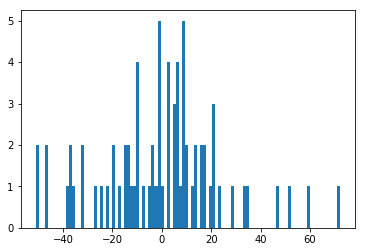

8 [148.845703125, 49.0625, 104.72265625, 75.162109375, 90.337890625, 36.78125, 35.068359375, 99.908203125, 79.201171875, 61.689453125, 30.57421875, 88.046875, 51.60698696862348, 60.05797697368421, 31.999098557692307, 41.6484375, 48.40574149408284, 85.72594253369493, 51.27456597222222, 53.263671875, 38.923828125, 34.0234375, 46.732421875, 54.9609375, 63.064453125, 46.330078125, 45.044921875, 47.953125, 90.671875, 59.4609375, 27.7265625, 49.533203125, 38.943359375, 25.119140625, 63.06640625, 20.36328125, 56.015625, 21.5859375] [102.763671875, 15.5, 45.484375, 30.669921875, 35.576171875, -9.4921875, -13.76953125, 49.212890625, -15.462890625, -8.439453125, 8.456208881578947, -8.9765625, -17.63042446862348, 14.209229504048587, 0.6787860576923066, -7.9375, -23.52683524408284, 18.194175809500322, -7.826996527777776, 5.837890625, -7.599609375, -13.1796875, -2.099609375, -37.39453125, 3.255859375, -9.998046875, 11.521484375, 9.6328125, -16.1875, -18.4375, 1.171875, 14.466796875, 21.900390625, 2

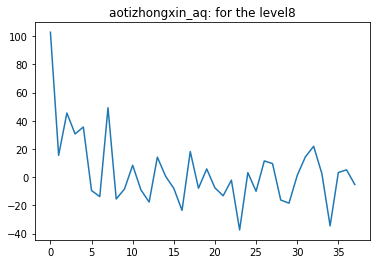

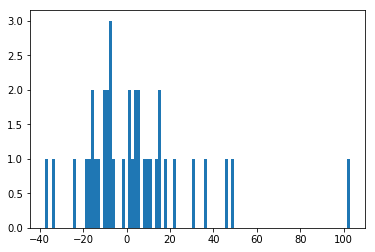

9 [98.9541015625, 89.9423828125, 63.5595703125, 67.48828125, 70.4453125, 59.310546875, 55.83248197115385, 36.82376802884615, 67.06584201388888, 52.26911892361111, 36.4736328125, 50.8466796875, 54.697265625, 46.4990234375, 75.06640625, 38.6298828125, 32.03125, 41.71484375, 38.80078125] [49.8916015625, 14.7802734375, 26.7783203125, -32.419921875, 8.755859375, -28.736328125, -4.225495002530366, -4.824669471153847, -18.660100519806047, -0.99455295138889, 2.4501953125, -4.1142578125, 8.3671875, -1.4541015625, 15.60546875, -10.9033203125, 6.912109375, 21.3515625, 17.21484375]


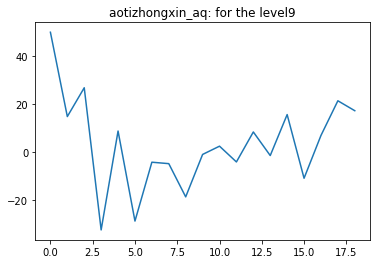

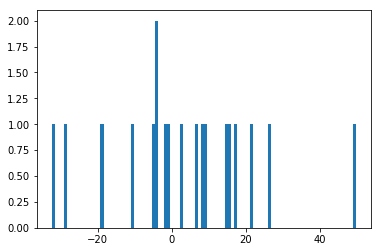

10 [94.4482421875, 65.52392578125, 64.8779296875, 46.328125, 59.66748046875, 44.37137586805555, 52.77197265625, 60.78271484375, 35.33056640625, 40.2578125] [4.505859375, -1.96435546875, 5.5673828125, 9.504356971153847, 7.398361545138886, 7.897743055555555, -1.92529296875, -14.28369140625, 3.29931640625, 1.45703125]


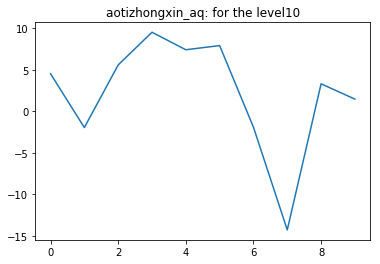

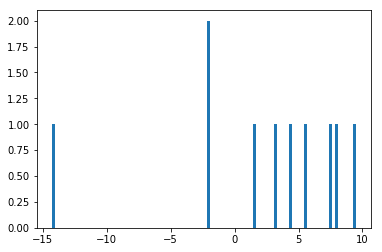

11 [79.986083984375, 55.60302734375, 52.019428168402776, 56.77734375, 37.794189453125] [14.462158203125, 9.27490234375, 7.648052300347224, -4.00537109375, -2.463623046875]


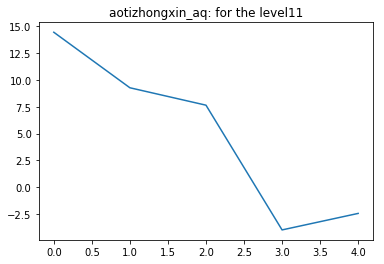

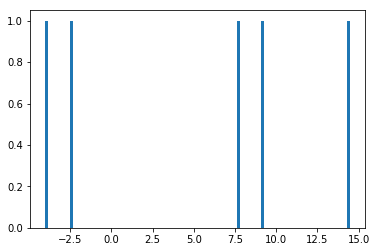

12 [67.7945556640625, 54.10480685763889, 47.2857666015625] [12.1915283203125, -0.2935791015625, 9.4915771484375]


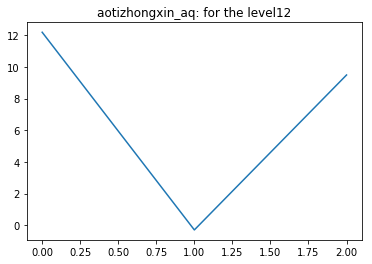

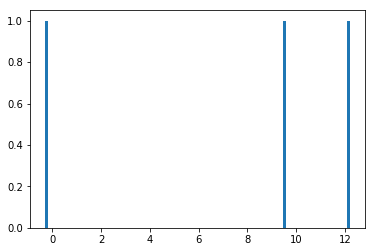

13 [60.949681260850696, 50.695286729600696] [6.844874403211804, 3.4095201280381957]


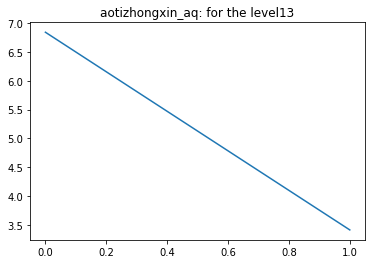

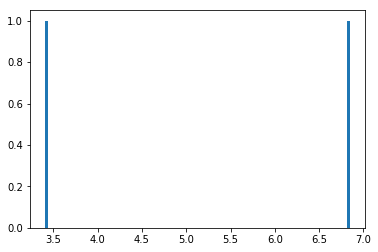

14 [55.822483995225696] [5.127197265625]


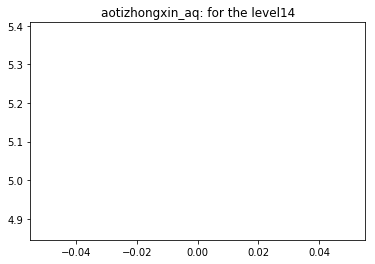

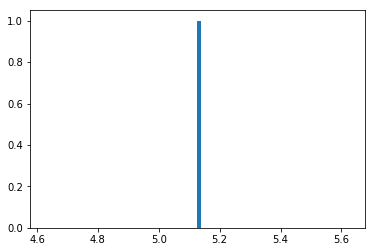

6
[274.625, 228.59375, 54.4921875, 37.671875, 27.34375, 101.78125, 40.578125, 26.546875, 103.19140625, 197.22265625, 72.984375, 45.4921875, 165.65625, 46.0078125, 8.609375, 80.375, 198.14453125, 53.68359375, 63.3359375, 46.1875, 17.921875, 36.65625, 51.734375, 40.8125, 8.421875, 34.17578125, 10.35546875, 87.3203125, 182.25, 115.9921875, 85.1875, 16.203125, 92.3046875, 35.171875, 111.0, 78.328125, 74.046875, 32.453125, 50.78125, 89.4765625, 45.8328125, 32.228042763157895, 21.618832236842103, 22.6171875, 41.984375, 116.15625, 148.6328125, 45.4140625, 42.328125, 25.625, 47.6875, 90.78732287449392, 79.4493927125506, 69.08502024291498, 58.72064777327935, 32.9768471659919, 25.32451923076923, 40.03125, 40.796875, 21.84375, 31.234375, 36.1875, 66.234375, 32.9375, 27.2109375, 22.546875, 71.3828125, 72.48234097633136, 102.59467455621301, 105.2455621301775, 84.7555473372781, 50.30798611111111, 32.223263888888894, 54.671875, 56.421875, 68.890625, 25.9609375, 31.625, 31.0234375, 53.203125, 39.84375

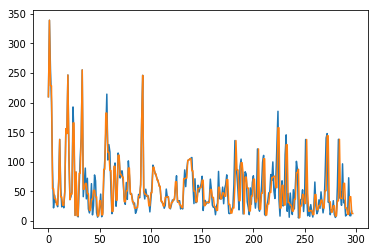

In [16]:
import random



# 觀察table的level, difference的關係, choose some sensors
tables = {}
for s in stations[:1]:
    print(s)
    v = time_series(s, 'PM2.5')
    v = interpolate_linear1d(v)
    print(len(v))
    tables[s] = wavelet_coefficient_table(v)

    
def wavelet_coefficient_distribution(level, list_diff, stationid):
    # ex: {1: [x, x, x,... ]}
    '''
    output: a plot and distribution plot.
    Use this fuction many times, can obtain all coefficients for different levels and its frequency
    '''
#     plt.plot([1, 2, 3, 4], [1, 4, 9, 16], 'ro')
    
    xdata = range(len(list_diff))
    plt.plot(xdata, list_diff)
    plt.title(label=str(stationid)+": for the level" + str(level))
    plt.show()
    # distribution histogram
    bin_value = plt.hist(list_diff, bins = 100)    # bins now no matters, just help to show
    plt.show()
#     print(bin_value)
    
    
# 給一個level, try不同alpha(threshold概念)，filter需要的係數，用他們來還原成上一個level的資料
# 當然alpha越高越像，因為會包含更多係數，但是變像的程度若不夠大只有一點點幫助那就定住，return final optimal-alpha
def inverse_transform(level, datas_avg, datas_dif, alpha=0.1):
    # 先能產生一個boundary..
    boundary = '?'
    
    # diff取絕對值
    print("取絕對值")
    abs_diff = list(map(abs, datas_dif))
    print(abs_diff)
    abs_diff.sort(reverse=True)
    print(datas_dif)
    print(abs_diff)
    
    try:
        boundary = abs_diff[int(len(datas_dif)*alpha)]
    except IndexError:
        boundary = 0 # no threshold
    print("bounadary is %f" %(boundary))
    
    # gen a pair(i, j) 以取代一堆bool, 這是標記出level i, 的第j位超過要的boundary
    evolving = []
    
    for i in range(len(datas_dif)):
        if abs(datas_dif[i]) >= boundary:
            evolving.append((level, i))
        else:
            datas_dif[i] = 0 # filter too small fluctuation
    print(datas_dif)
    print(len(datas_avg), len(datas_dif), len(evolving))
    
    # 至於如何inverse, 就先用簡單的斜率概念，反正這也只是前後相減值, 目前想法：我就當那些相減值為0, 也就是不變(那段＝constant)
    inversed_data = []  # 長度是datas的2倍
    for x, y in zip(datas_avg, datas_dif):
        inversed_data.extend([x+y, x-y])
    return inversed_data


for x in tables['aotizhongxin_aq'][1:]:
    print(x[0], x[1], x[2]) # level, average, difference
    pic = wavelet_coefficient_distribution(x[0], x[2], 'aotizhongxin_aq')
# #     break


test = tables['aotizhongxin_aq'][6]


level, average, diff = test[0], test[1], test[2]

# level = 3
# average = [1, 7, 10, 20]
# diff = [0, -1, -1, -5]
print(level)
print(average)
print(diff)

inv = inverse_transform(level, average, diff)
print(inv)

y1 = tables['aotizhongxin_aq'][5][1]
y2 = inv
plt.plot(range(len(y1)), y1)
plt.plot(range(len(y2)), y2)
plt.show()
